1. Hyper-parameter Optimization for MLP on FMNIST
In this problem you will train an MLP with one hidden layer for the Fashion MNIST dataset. Use ReLU for the hidden-layer activation function. You will split the training dataset using an 80/20 split for a train/val split. This yields: 48,000 train images, 12,000 val images, and 10,000 test images. You will repeatedly train the MLP to optimize the following parameters:
• M: number of hidden nodes/units (the bias is not counted here – use convention from backprop handout which is same as that in tensorflow/pytorch)
• 𝜂: learning rate. Use the standard SGD optimizer, with shuffling and mini-batches.
• B: the mini-batch size.
• 𝜆: the L2 regularizer coefficient
You can use whatever training platform you like – e.g., tensorflow.keras, PyTorch, sklearn, or your own code. You have reference code for this exact training task using tensorflow.keras and PyTorch (GitHub’s Lecture directory) and the TA’s showed example of MLP training in sklearn in discussion.

In [ ]:
pip install torch.summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the necessary libraries: 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
import matplotlib.pyplot as plt
#import torch.summary as summary

In [ ]:
# Loading the fashion NMIST dataset:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Transforming the dataset into tensors and normalizing.
training_dataset = datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testing_dataset = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)
training_dataset, validation_dataset = random_split(training_dataset, [48000, 12000]) # 80/20% split of the training dataset into validation set.

100%|██████████| 26421880/26421880 [00:01<00:00, 15836148.23it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271578.87it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5142860.82it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19347918.45it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Hyper parameters:
M = 48 # Hidden nodes.
eeta = 0.01 # Learning rate.
weight_lambda = 1e-3 # Weight decay.
B = [32, 8, 16, 64, 128] # Batch size.
threshold_accuracy = 0.8 # Convergence accuracy.

In [ ]:
# Shuffling the datasets for SGD optimizer:
trainingdata_loader = DataLoader(training_dataset, batch_size = B[-1], shuffle = True)
# Initialize batch size to load the dataset:
validationdata_loader = DataLoader(validation_dataset, batch_size = B[-1])
testingdata_loader = DataLoader(testing_dataset, batch_size = B[-1])

In [ ]:
# Define the Neural Network (Multilayer Perceptron):
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(784, M) # Input nodes.
        self.relu = nn.ReLU() # Activation function.
        self.layer2 = nn.Linear(M, 10) # Output nodes.

    # Forward propagation:
    def forward(self, nodes):
        nodes = self.layer1(nodes)
        nodes = self.relu(nodes)
        nodes = self.layer2(nodes)
        return nodes

model = MLP() # Defining the model.
loss_function = nn.CrossEntropyLoss() # Loss/criterion/cost function.
optimizer_func = torch.optim.SGD(model.parameters(), lr = eeta, weight_decay = weight_lambda)

(a) Start with 𝑀 = 48 hidden nodes, 𝜂 = 0.01, 𝜆 = 10!" and 𝐵 = 32. These were used in the tf.keras/PyTorch examples shown by Prof. Chugg and available in the GitHub repository in the Lecture directory. Vary the batch size and time how long it takes to reach an accuracy of 80%.
Run 5 times and average the run times. Training runs will vary because the weights are randomly initialized. Select the batch size that has smallest run-time. Report this batch size. Also, for this batch size, report the sample mean and sample standard deviation of the 5 runtimes.
Use np.mean() and np.std() for this computation. For the remainder of this problem, use this batch size.

In [ ]:
epoch_loops = 5 
avglist_runtimes = []
stdlist_runtimes = []

# Training the model:
for mini_batch in B:
    print('Current mini batch size- ', mini_batch)
    runtimes_mini_batch = []
    trainingdata_loader = DataLoader(training_dataset, batch_size = mini_batch, shuffle = True)
    validationdata_loader = DataLoader(validation_dataset, batch_size = mini_batch, shuffle = False)
    
    for ele in range(epoch_loops):
        # Re-initializing the weights:
        model = MLP()
        optimizer_func = torch.optim.SGD(model.parameters(), lr = eeta, weight_decay = weight_lambda)
        print('Current run: ', ele + 1)
        start_looptime = time.time()
        accuracy = 0.0
        runtime_average = 0.0
        runtime_standard = 0.0
        
        while accuracy < threshold_accuracy: # Convergence condition.
            
            for iter, (pictures, true_labels) in enumerate(trainingdata_loader):
                pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
                optimizer_func.zero_grad()
                output = model(pictures)
                loss = loss_function(output, true_labels)
                loss.backward()
                optimizer_func.step()
            # Calculating the accuracy:
            with torch.no_grad():
                total_dataset = 0
                correct_prediction = 0
                # Validation run:
                for pictures, true_labels in validationdata_loader:
                    pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
                    output = model(pictures)
                    total_dataset += true_labels.size(0)
                    predicted_labels = torch.max(output.data, 1)[1]
                    correct_prediction += (predicted_labels == true_labels).sum().item()
                    accuracy = correct_prediction / total_dataset
                
                if accuracy > 0.8:
                  print('Validation accuracy: ', accuracy * 100, '%')
        
        end_looptime = time.time()
        currentepoch_runtime = end_looptime - start_looptime # Computing the run the for the current epoch.
        print('Run time: ', currentepoch_runtime)
        print('+' * 50)
        runtimes_mini_batch.append(currentepoch_runtime)
    
    runtime_average = np.mean(runtimes_mini_batch)
    runtime_standard = np.std(runtimes_mini_batch)
    stdlist_runtimes.append(runtime_standard)
    avglist_runtimes.append(runtime_average)
    print('Average run time: ', runtime_average)
    print('Standard deviation of the run time: ', runtime_standard)
    print('..==..' * 50)

Current mini batch size-  32
Current run:  1
Validation accuracy:  81.60833333333333 %
Run time:  15.783373355865479
++++++++++++++++++++++++++++++++++++++++++++++++++
Current run:  2
Validation accuracy:  81.66666666666667 %
Run time:  15.318180561065674
++++++++++++++++++++++++++++++++++++++++++++++++++
Current run:  3
Validation accuracy:  81.44166666666666 %
Run time:  15.979659795761108
++++++++++++++++++++++++++++++++++++++++++++++++++
Current run:  4
Validation accuracy:  80.65 %
Run time:  16.386348962783813
++++++++++++++++++++++++++++++++++++++++++++++++++
Current run:  5
Validation accuracy:  80.45833333333333 %
Run time:  15.478584051132202
++++++++++++++++++++++++++++++++++++++++++++++++++
Average run time:  15.789229345321655
Standard deviation of the run time:  0.37715708731941605
..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==...

In [ ]:
smallest_batchsize = B[np.argmin(avglist_runtimes)]
print('The batch size with the shortest run time: ', smallest_batchsize)
print('The sample mean for the optimal batch size: ', avglist_runtimes[np.argmin(avglist_runtimes)])
print('The sample standard deviation for the optimal batch size: ', stdlist_runtimes[np.argmin(stdlist_runtimes)])

The batch size with the shortest run time:  32
The sample mean for the optimal batch size:  15.789229345321655
The sample standard deviation for the optimal batch size:  0.26701250590291925


(b) Perform a grid search over the following hyper-parameters:
• 𝜂 ∈ {0.001,0.01, 0.1}
• 𝜆 ∈ {1𝑒 − 4 , 1𝑒 − 3, 1𝑒 − 2}
• Number of hidden nodes 𝑀 ∈ {40,80, 160}
Train to 30 epochs for each of the 27 combinations. For each value of hidden nodes, produce learning curves (include train/val and do for both loss/accuracy plots). Use the best val performance to select the value of these 3 hyper-parameters.

In [ ]:
# Hyper parameters:
eeta_new = [0.001, 0.01, 0.1] # Learning rates.
weight_lambda_new = [1e-4, 1e-3, 1e-2] # Weight decays.
# Hidden nodes:
M_new = [40, 80, 160]
epoch_new = 30
best_accuracy = 0

Current number of hidden nodes-  40
Current learning rate-  0.001
Current weight decay-  0.0001


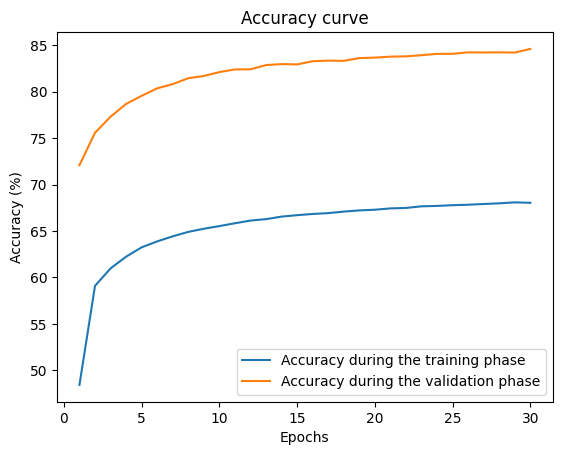

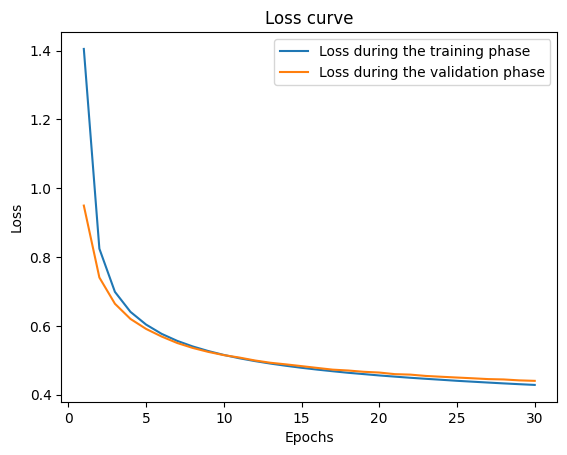

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.001
Current weight decay-  0.001


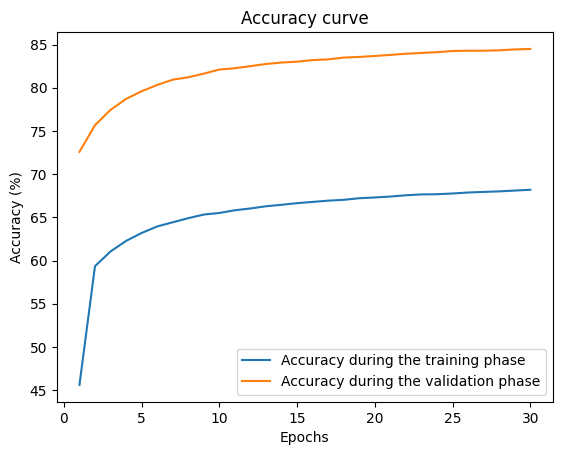

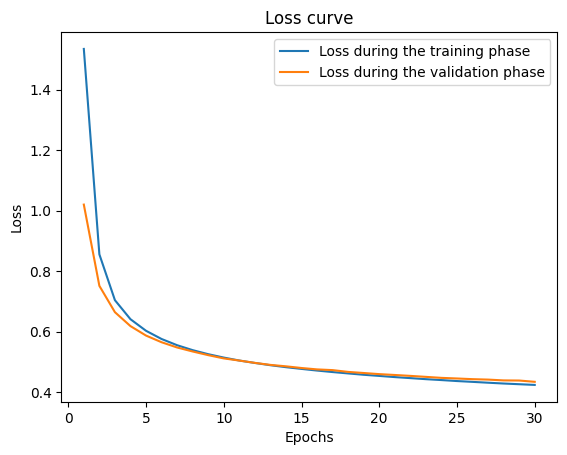

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.001
Current weight decay-  0.01


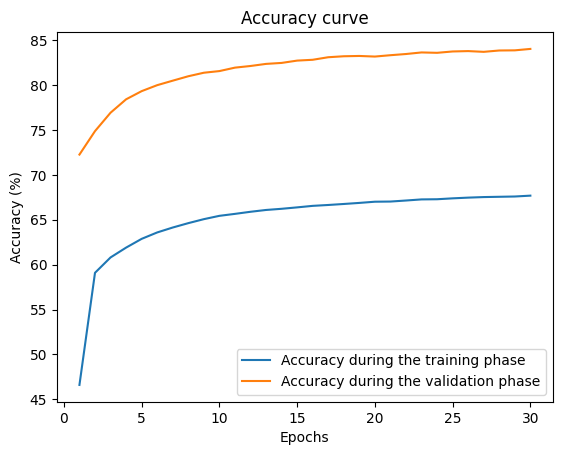

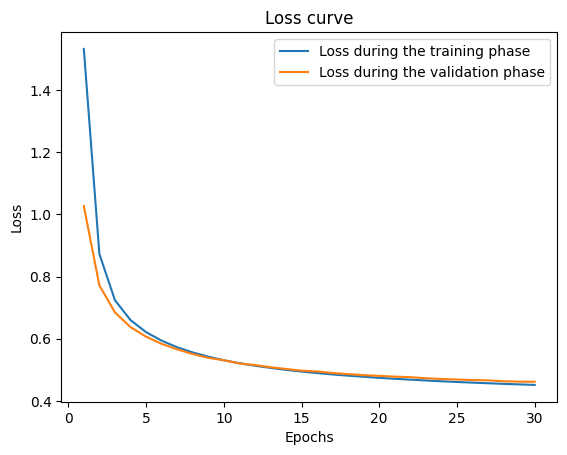

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.01
Current weight decay-  0.0001


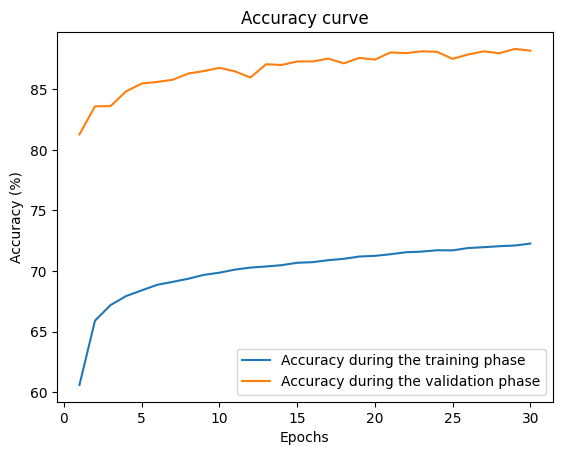

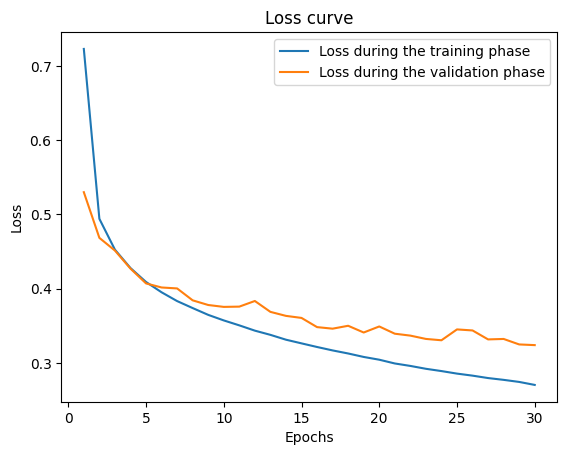

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.01
Current weight decay-  0.001


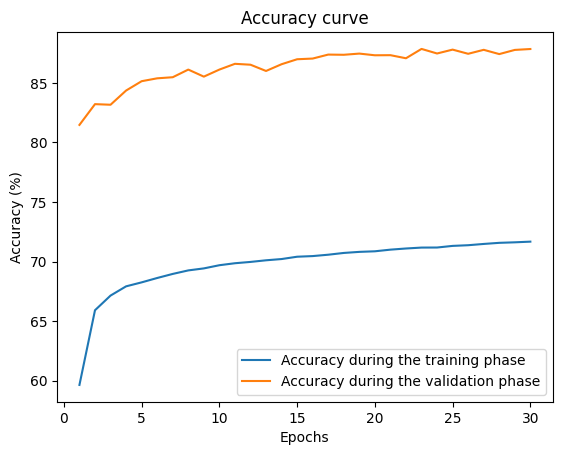

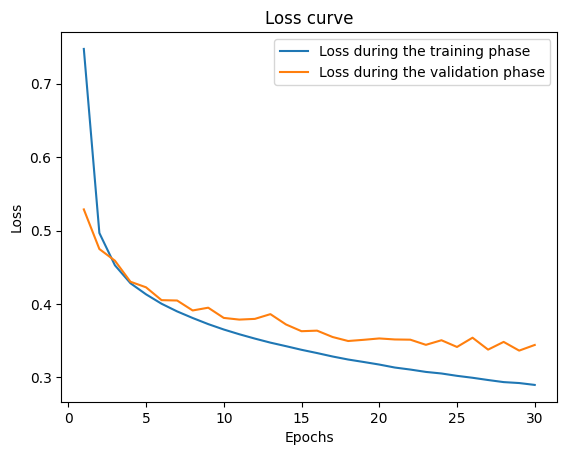

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.01
Current weight decay-  0.01


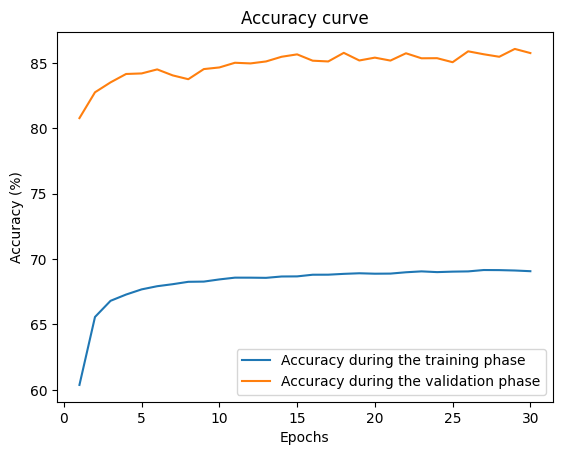

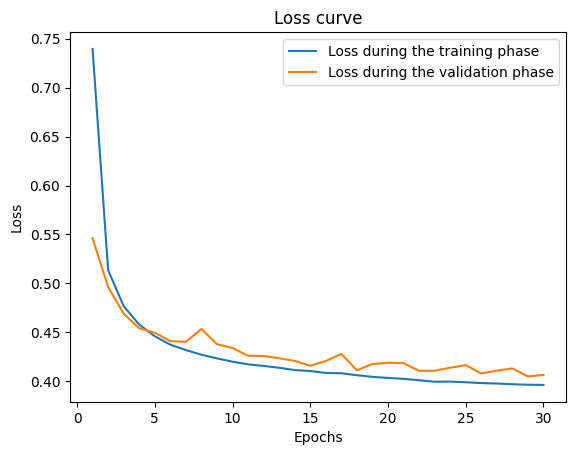

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.1
Current weight decay-  0.0001


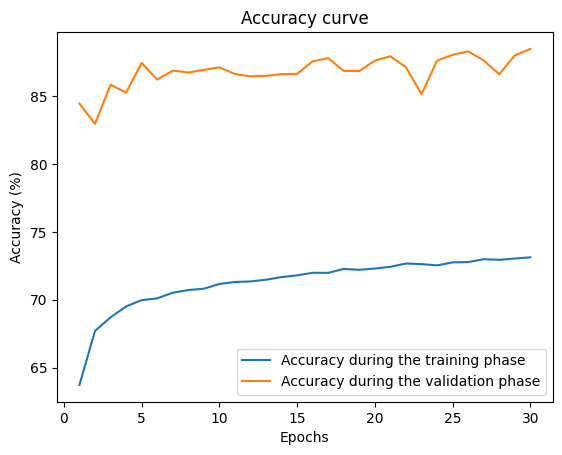

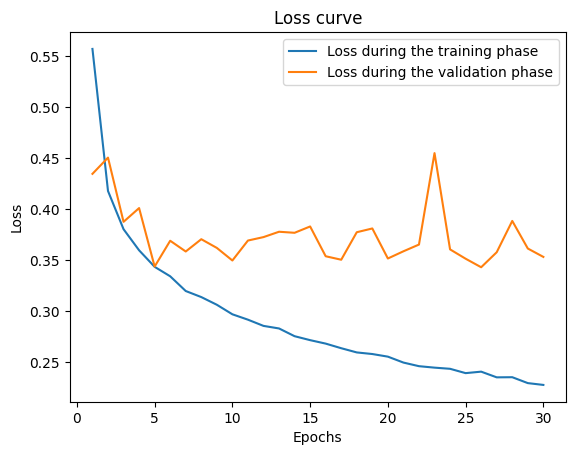

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.1
Current weight decay-  0.001


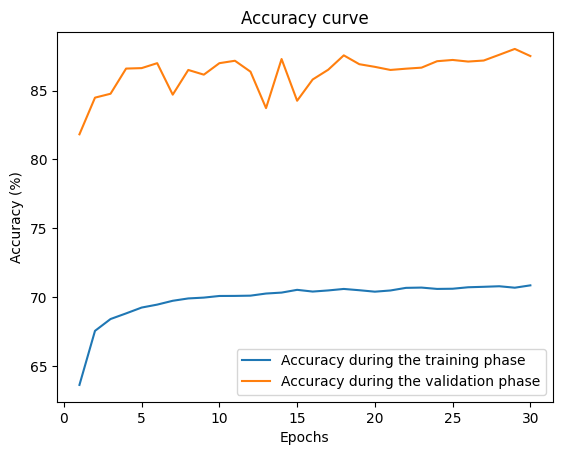

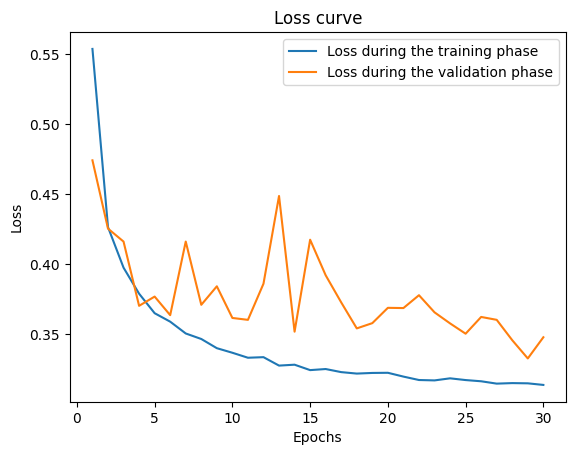

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  40
Current learning rate-  0.1
Current weight decay-  0.01


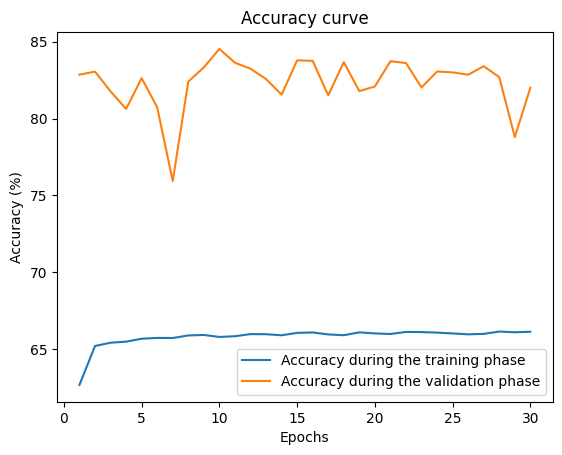

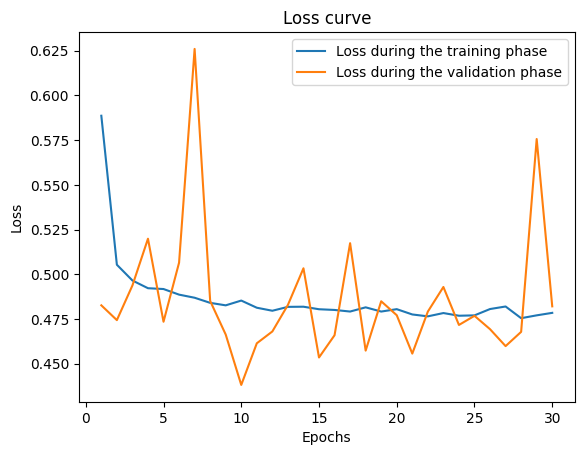

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.001
Current weight decay-  0.0001


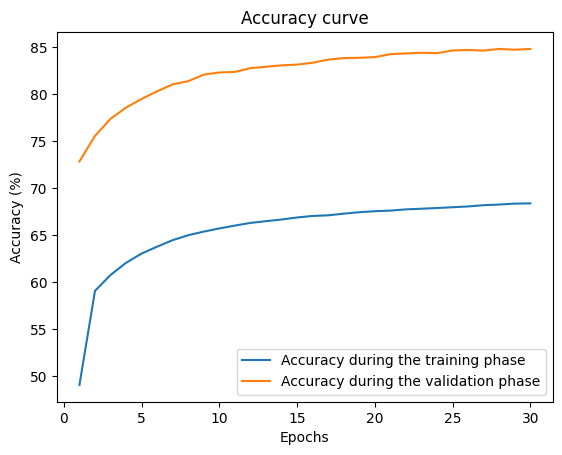

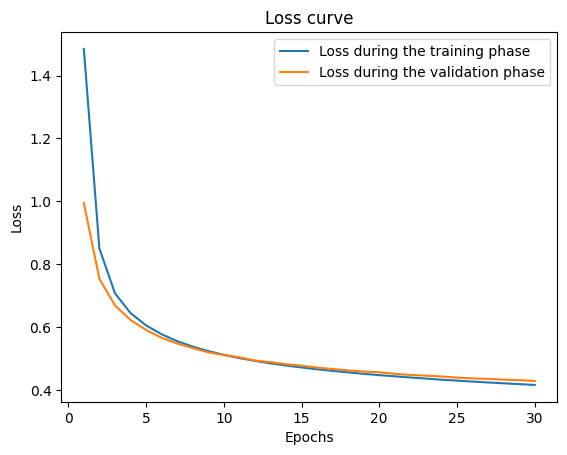

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.001
Current weight decay-  0.001


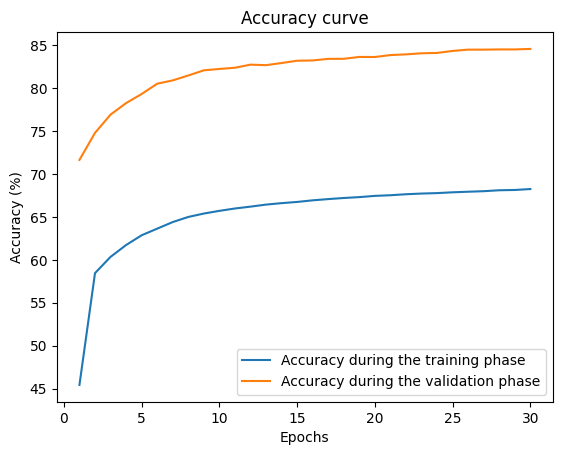

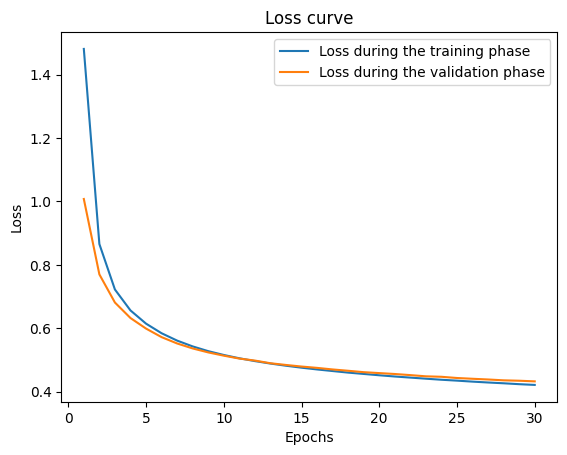

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.001
Current weight decay-  0.01


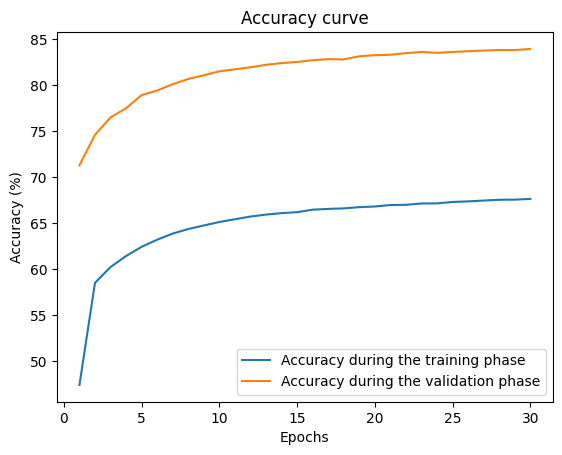

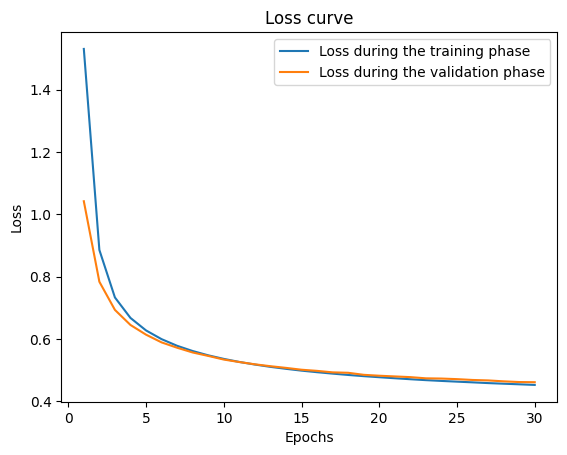

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.01
Current weight decay-  0.0001


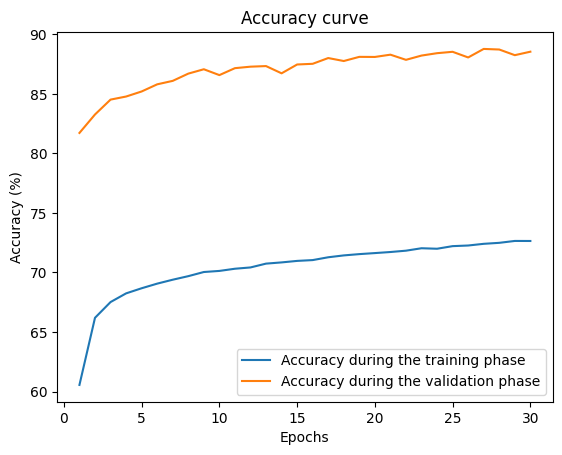

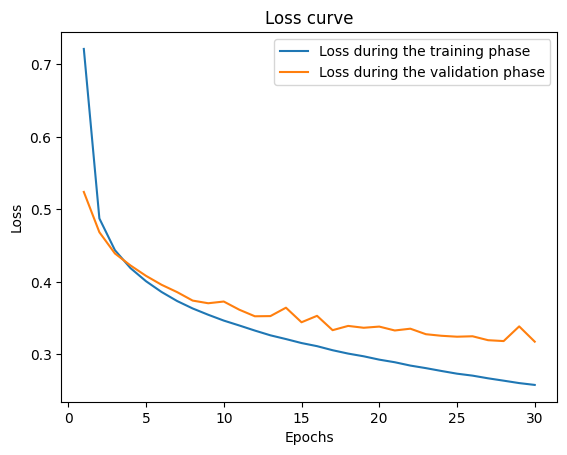

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.01
Current weight decay-  0.001


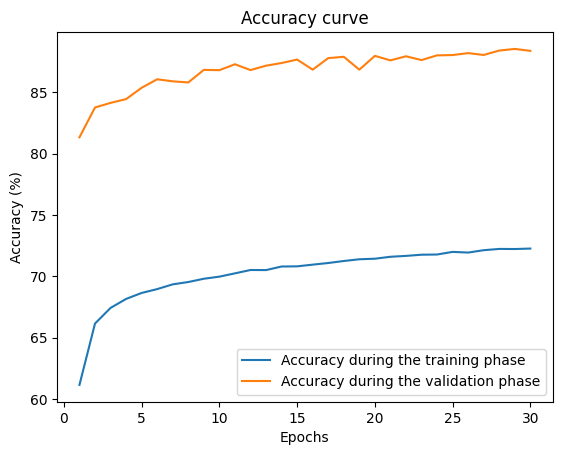

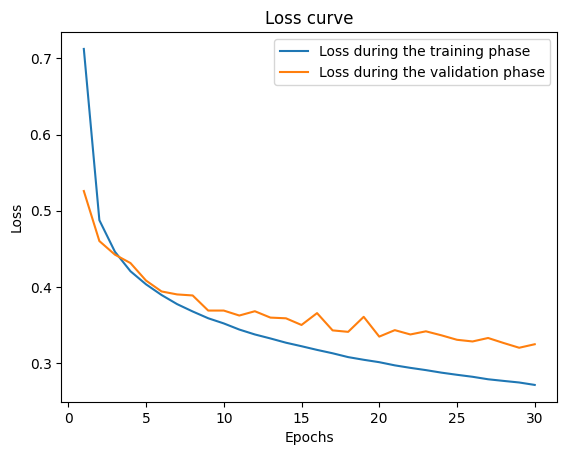

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.01
Current weight decay-  0.01


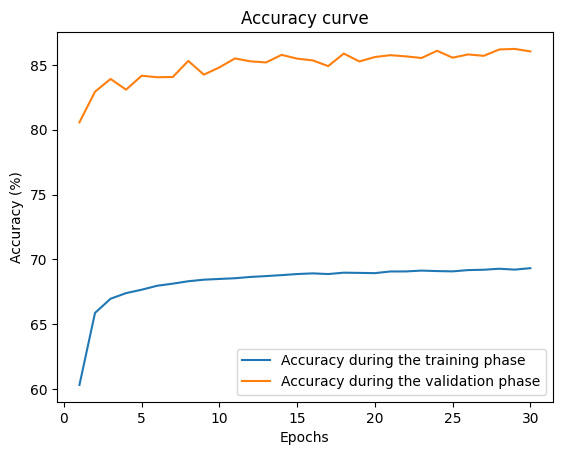

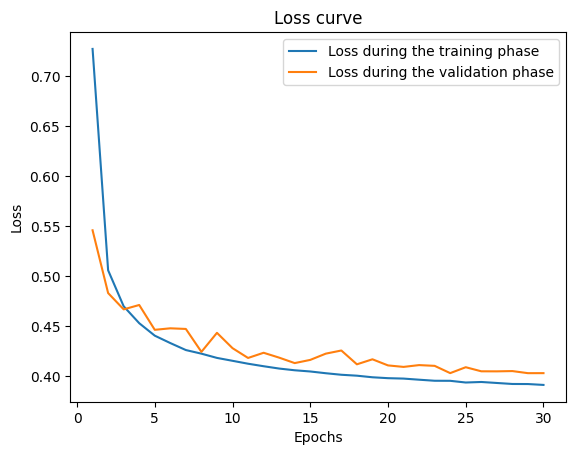

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.1
Current weight decay-  0.0001


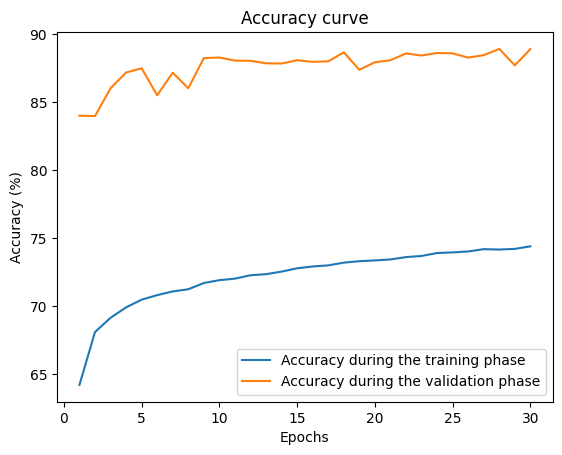

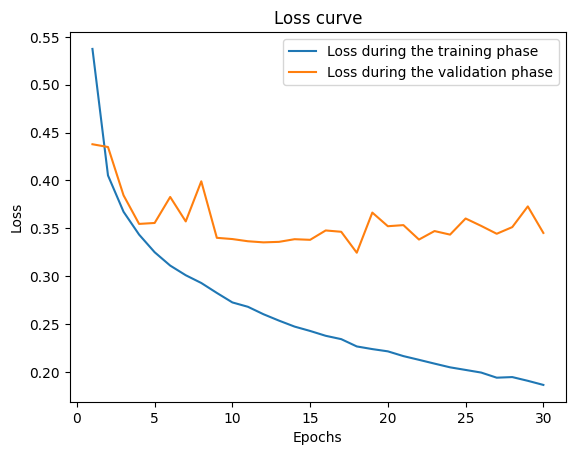

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.1
Current weight decay-  0.001


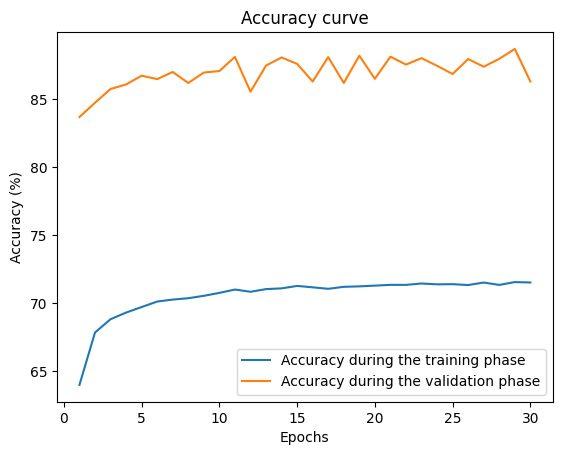

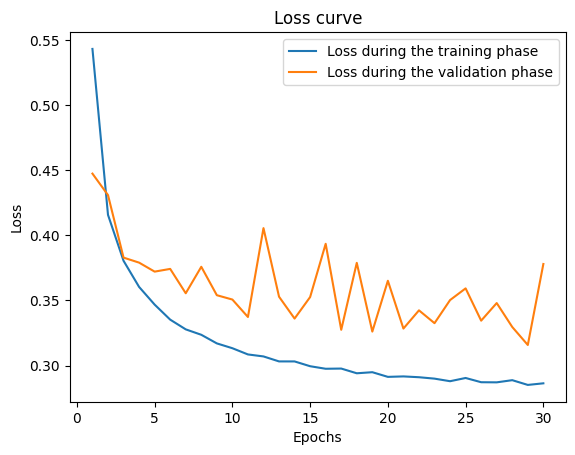

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  80
Current learning rate-  0.1
Current weight decay-  0.01


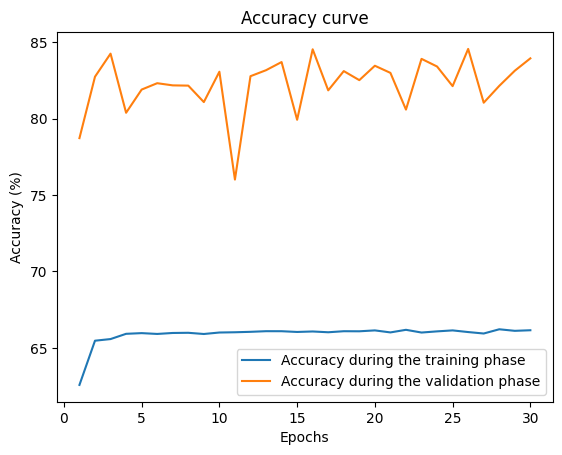

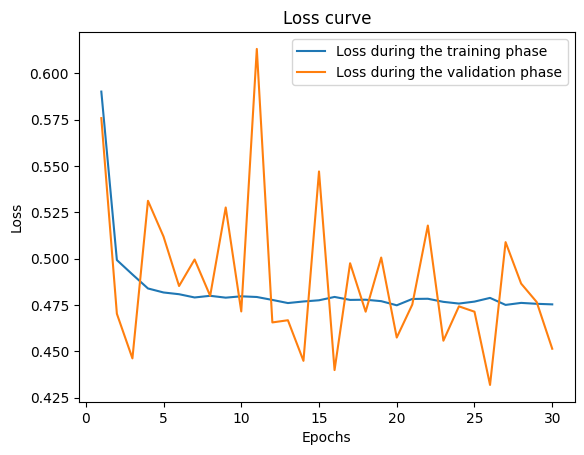

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.001
Current weight decay-  0.0001


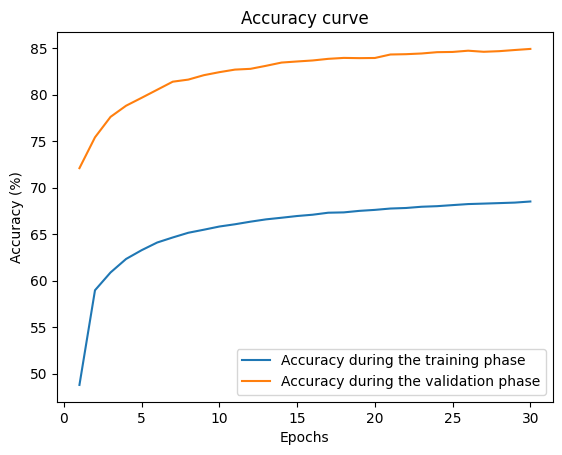

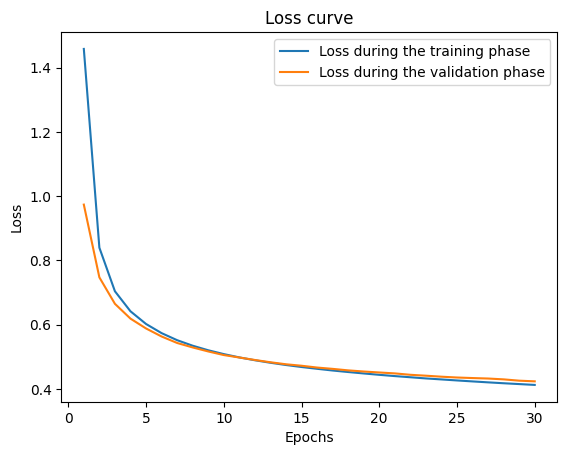

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.001
Current weight decay-  0.001


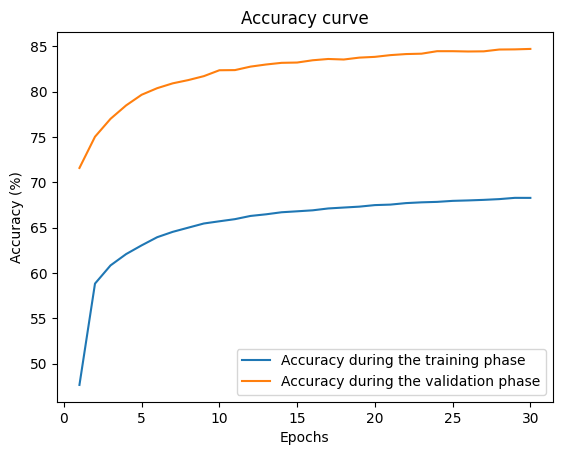

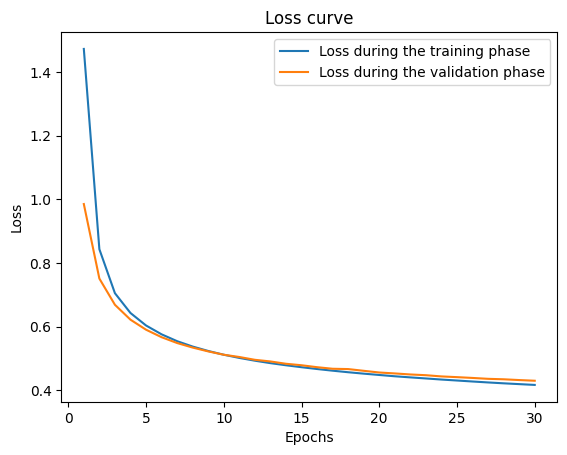

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.001
Current weight decay-  0.01


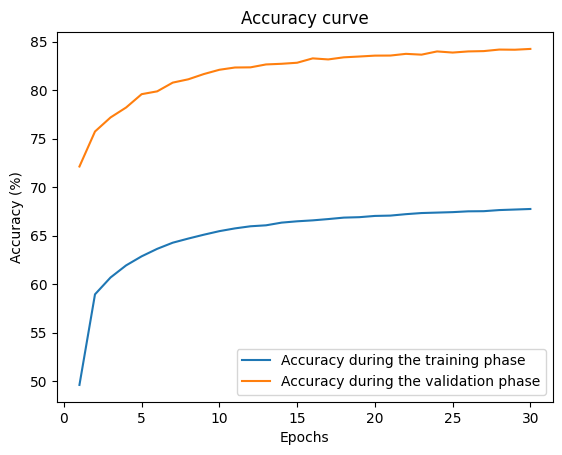

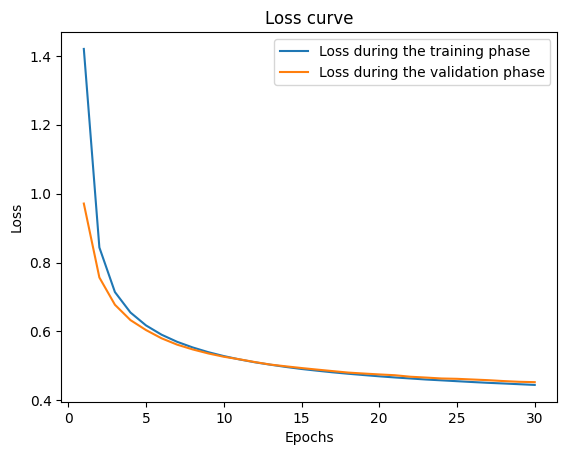

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.01
Current weight decay-  0.0001


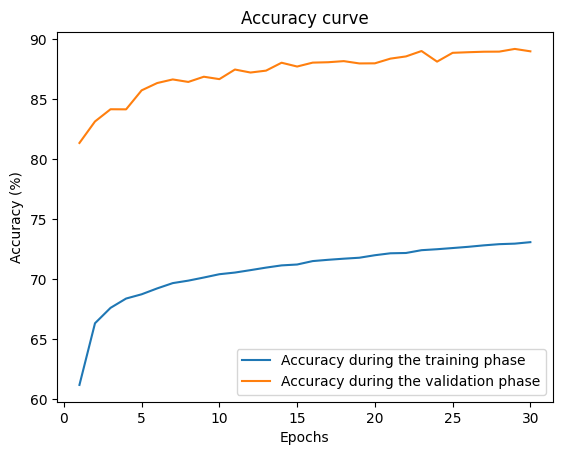

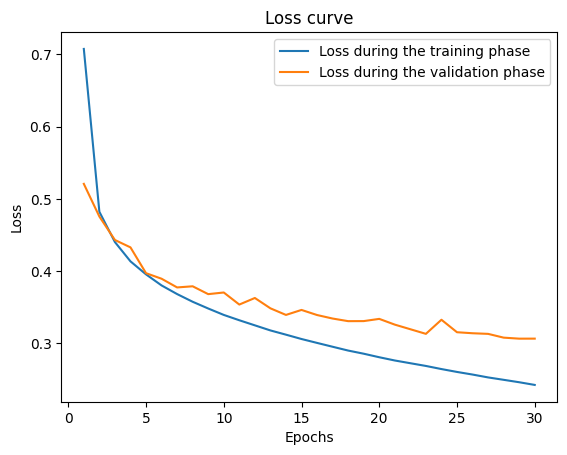

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.01
Current weight decay-  0.001


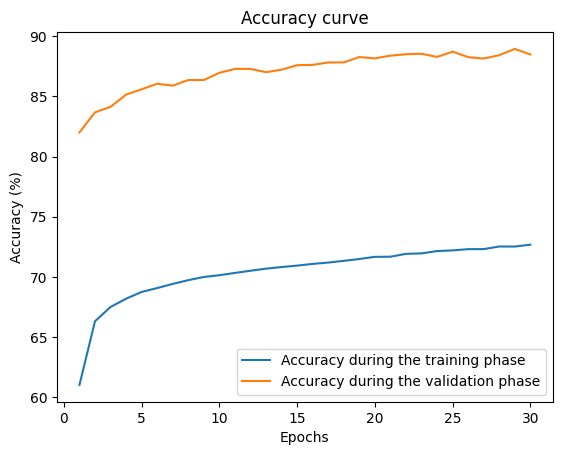

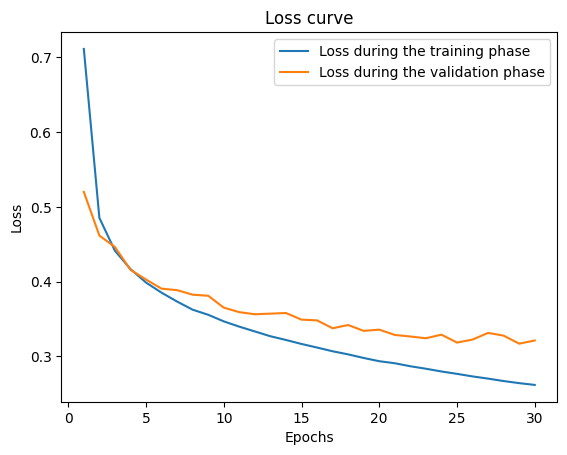

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.01
Current weight decay-  0.01


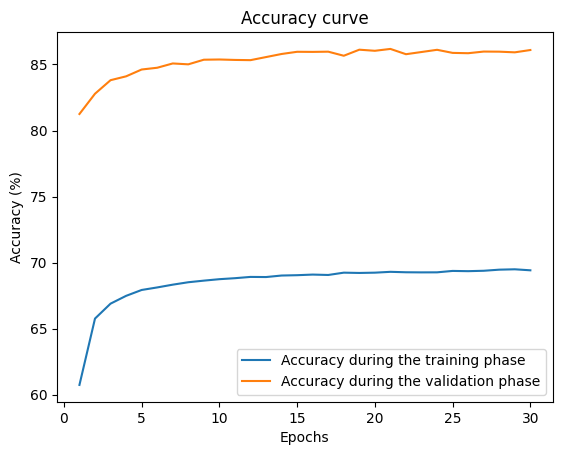

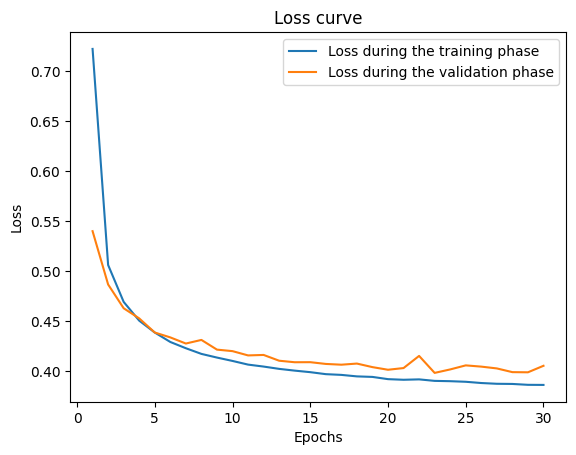

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.1
Current weight decay-  0.0001


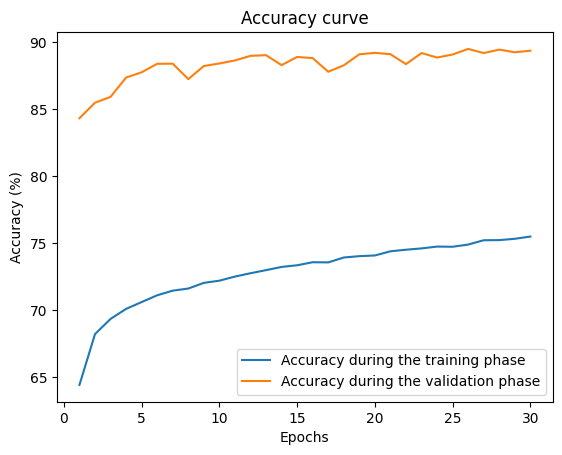

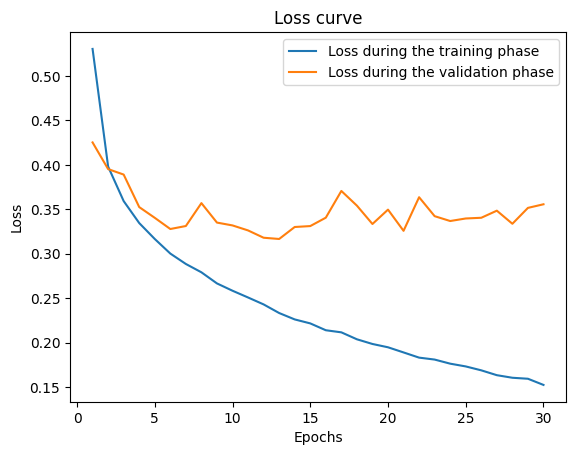

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.1
Current weight decay-  0.001


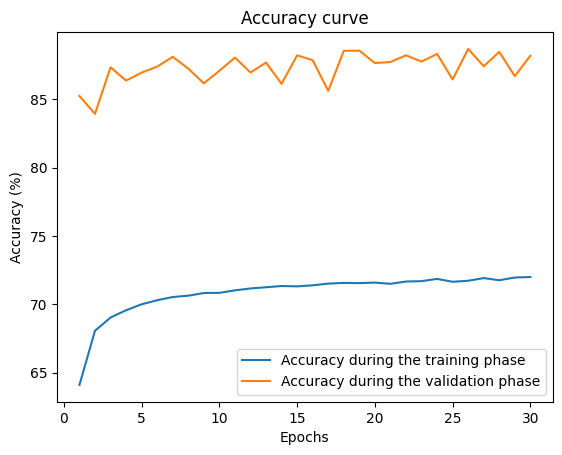

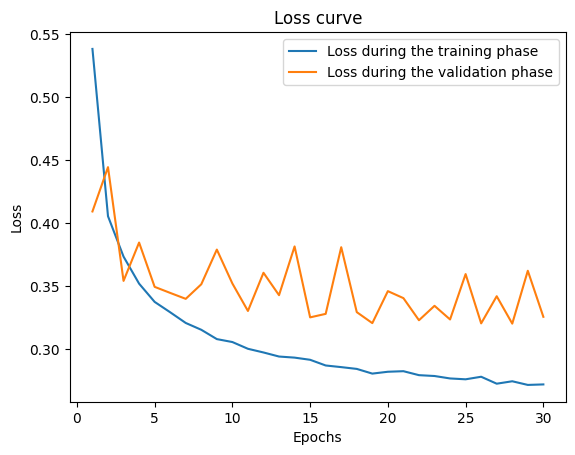

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..
Current number of hidden nodes-  160
Current learning rate-  0.1
Current weight decay-  0.01


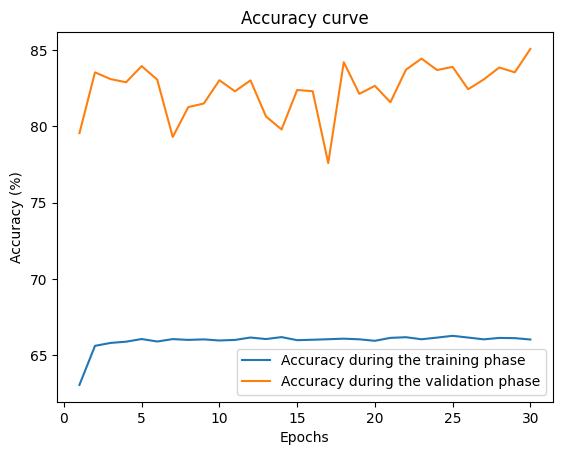

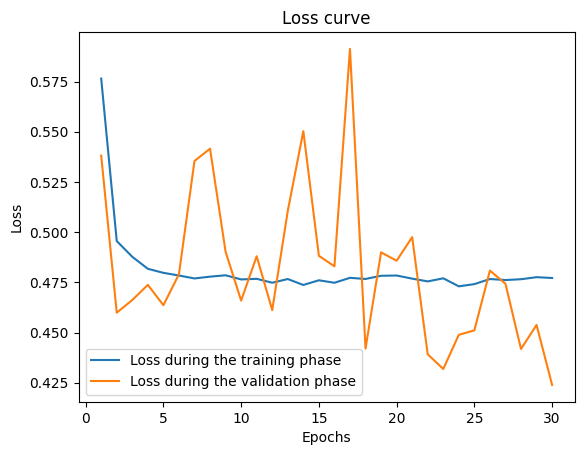

..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..


In [ ]:
for hn in M_new:
  for learn in eeta_new:
    for lamb in weight_lambda_new:
      # Define the Neural Network (Multilayer Perceptron):
      class MLP_1(nn.Module):
          def __init__(self):
              super(MLP_1, self).__init__()
              self.layer1 = nn.Linear(784, hn) # Input nodes.
              self.relu = nn.ReLU() # Activation function.
              self.layer2 = nn.Linear(hn, 10) # Output nodes.

          # Forward propagation:
          def forward(self, nodes):
              nodes = self.layer1(nodes)
              nodes = self.relu(nodes)
              nodes = self.layer2(nodes)
              return nodes

      model_new = MLP_1() # Defining the model.
      loss_function_new = nn.CrossEntropyLoss() # Loss/criterion/cost function.
      optimizer_func_new = torch.optim.SGD(model_new.parameters(), lr = learn, weight_decay = lamb)
      
      list_trainloss = []
      list_valloss = []
      training_accuracy = []
      validation_accuracy = []

      # Training the model:
      print('Current number of hidden nodes- ', hn)
      print('Current learning rate- ', learn)
      print('Current weight decay- ', lamb)
      trainingdata_loader = DataLoader(training_dataset, batch_size = smallest_batchsize, shuffle = True)
      validationdata_loader = DataLoader(validation_dataset, batch_size = smallest_batchsize, shuffle = False)
      
      for ele in range(epoch_new):
          train_accuracy = 0.0
          training_loss = 0.0
          validation_loss = 0.0
          predicted_correct = 0.0
          
          for iter, (pictures, true_labels) in enumerate(trainingdata_loader):
              pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
              optimizer_func_new.zero_grad()
              output = model_new(pictures)
              loss = loss_function_new(output, true_labels)
              loss.backward()
              optimizer_func_new.step()
              total_dataset += true_labels.size(0)
              training_loss += loss.item()
              train_labels = torch.max(output, 1)[1]
              predicted_correct += torch.sum(train_labels == true_labels.data)
          
          list_trainloss.append(training_loss / len(trainingdata_loader))
          training_accuracy.append(predicted_correct / total_dataset)  

          # Calculating the accuracy:
          with torch.no_grad():
              correct_prediction = 0
              total_dataset = 0
              # Validation run:
              for pictures, true_labels in validationdata_loader:
                  pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
                  output = model_new(pictures)
                  loss = loss_function_new(output, true_labels)
                  validation_loss += loss.item()
                  predicted_labels = torch.max(output, 1)[1]
                  correct_prediction += torch.sum(predicted_labels == true_labels.data)
                  total_dataset += true_labels.size(0)
                  
              validation_accuracy.append(correct_prediction / total_dataset)
              list_valloss.append(validation_loss / len(validationdata_loader))

      # Extracting the best hyper parameters:
      if validation_accuracy[-1] > best_accuracy:
        best_accuracy = validation_accuracy[-1]
        optimal_params = (hn, learn, lamb)

    # Plotting the accuracy graph:
      plt.title("Accuracy curve")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy (%)")
      plt.plot(range(1, epoch_new + 1), np.array(training_accuracy) * 100, label = "Accuracy during the training phase")
      plt.plot(range(1, epoch_new + 1), np.array(validation_accuracy) * 100, label = "Accuracy during the validation phase")
      plt.legend()
      plt.show()

      # Plotting the loss graph:
      plt.title("Loss curve")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.plot(range(1, epoch_new + 1), np.array(list_trainloss), label = "Loss during the training phase")
      plt.plot(range(1, epoch_new + 1), np.array(list_valloss), label = "Loss during the validation phase")
      plt.legend()
      plt.show()

      print('..==..' * 50)

In [ ]:
print(f'The optimal number of hidden nodes: {optimal_params[0]}, the optimal learning rate: {optimal_params[1]} and the optimal weight decay: {optimal_params[2]}')

The optimal number of hidden nodes: 160, the optimal learning rate: 0.1 and the optimal weight decay: 0.0001


(c) For the best hyper-parameters found in part (b), run 5 training runs out to 100 epochs. Report the best accuracy (over epochs) on val for each run - this is 5 numbers. Compute, mean, max, and std deviation for these 5 values.

In [ ]:
optimal_M = optimal_params[0]
optimal_weightdecay = optimal_params[2]
optimal_lr = optimal_params[1]
epochs = 100

In [ ]:
# Define the Neural Network (Multilayer Perceptron):
class MLP_op(nn.Module):
    def __init__(self):
        super(MLP_op, self).__init__()
        self.layer1 = nn.Linear(784, optimal_M) # Input nodes.
        self.relu = nn.ReLU() # Activation function.
        self.layer2 = nn.Linear(optimal_M, 10) # Output nodes.

    # Forward propagation:
    def forward(self, nodes):
        nodes = self.layer1(nodes)
        nodes = self.relu(nodes)
        nodes = self.layer2(nodes)
        return nodes

model_op = MLP_op() # Defining the model.
loss_function_op = nn.CrossEntropyLoss() # Loss/criterion/cost function.
optimizer_func_op = torch.optim.SGD(model_op.parameters(), lr = optimal_lr, weight_decay = optimal_weightdecay)

In [ ]:
epoch_runs = 5 
val_acc = []
best_valacc = 0
i = 0

# Training the model:
for ele in range(epoch_runs):
    # Re-initializing the weights:
    model_op = MLP_op()
    optimizer_func_op = torch.optim.SGD(model_op.parameters(), lr = optimal_lr, weight_decay = optimal_weightdecay)
    trainingdata_loader = DataLoader(training_dataset, batch_size = smallest_batchsize, shuffle = True)
    validationdata_loader = DataLoader(validation_dataset, batch_size = smallest_batchsize, shuffle = False)
    accuracy = []

    while i < epochs:
      
      for iter, (pictures, true_labels) in enumerate(trainingdata_loader):
          pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
          optimizer_func_op.zero_grad()
          output = model_op(pictures)
          loss = loss_function_op(output, true_labels)
          loss.backward()
          optimizer_func_op.step()
      # Calculating the accuracy:
      with torch.no_grad():
          total_dataset = 0
          correct_prediction = 0
          # Validation run:
          for pictures, true_labels in validationdata_loader:
              pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
              output = model_op(pictures)
              total_dataset += true_labels.size(0)
              predicted_labels = torch.max(output.data, 1)[1]
              correct_prediction += (predicted_labels == true_labels).sum().item()
              
          accuracy.append(correct_prediction / total_dataset)
      
      i += 1
      val_acc.append(accuracy)

    if val_acc[-1] > best_valacc:
      best_valacc = val_acc[-1]
      print("Saving the optimal model \n")
      torch.save(model_op,"optimal_model.pt")

    print(f'Validation accuracy for run-{ele + 1}: ', val_acc[-1] * 100, '%') 
    
print('Average validation accuracy: ', np.mean(val_acc))
print('Standard deviation of the validation accuracy: ', np.std(val_acc))
print('The maximum accuracy: ', max(val_acc) * 100, '%')
print('..==..' * 50)

Saving the optimal model 

Validation accuracy for run-1:  89.70833333333333 %
Validation accuracy for run-2:  89.70833333333333 %
Validation accuracy for run-3:  89.70833333333333 %
Validation accuracy for run-4:  89.70833333333333 %
Validation accuracy for run-5:  89.70833333333333 %
Average validation accuracy:  0.8921374999999996
Standard deviation of the validation accuracy:  0.010401224387061373
The maximum accuracy:  89.70833333333333 %
..==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==....==..


(d) Take best model from part c (highest val accuracy) and evaluate on test. Report the test accuracy. Report the number of trainable parameters and all hyper-parameters used to obtain this final best model.

In [ ]:
# Loading the best model:
model_1d = MLP_op()
model_1d.load_state_dict(torch.load('optimal_model.pt')) # Fitting the optimal model from the saved file.
testingdata_loader = DataLoader(testing_dataset, batch_size = smallest_batchsize) # Loading the test dataset with the best batch size.

In [ ]:
testing_accuracy = 0

with torch.no_grad():
    total_dataset = 0
    correct_prediction = 0.0
    # Test run:
    for pictures, true_labels in testingdata_loader:
        pictures = pictures.reshape(-1, 28 * 28) # Resizing the images for a faster run time.
        true_labels = true_labels
        output = model_1d(pictures)
        predicted_labels = torch.max(output.data, 1)[1]
        total_dataset = true_labels.size(0)
        correct_prediction += (predicted_labels == true_labels).sum().item()
    
    testing_accuracy = correct_prediction / total_dataset # Computing the accuracy.

print('The accuracy during the testing phase: ', testing_accuracy * 100, '%')
# Printing the trainable parameters:
summary(model_1d, input_size = (3, 28, 28))
# Printing the hyper parameters:
print('Final hyper-parameters')
print('-' * 15)
print('The number of hidden nodes: ', optimal_M, "(M)")
print('The batch size: ', smallest_batchsize, "(B)")
print('The learning rate: ', optimal_lr, "(𝜂)")
print('The weight decay: ', optimal_weightdecay, "(𝜆)")